In [1]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
import math
import numpy as np
sys.path.append('../../pytools')
import d2l
import collections
import re
import random

d2l.gpu_mem_init()

2026-01-31 14:58:19.343642: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-31 14:58:19.406584: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-31 14:58:20.878178: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [3]:
num_hiddens = 512
rnn_cell = tf.keras.layers.SimpleRNNCell(num_hiddens,
    kernel_initializer='glorot_uniform')
rnn_layer = tf.keras.layers.RNN(rnn_cell,
    return_sequences=True, return_state=True)

state = rnn_cell.get_initial_state(batch_size=batch_size)
print(tf.squeeze(tf.convert_to_tensor(state)).shape)

(32, 512)


I0000 00:00:1769842702.055550  582319 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13656 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:08.0, compute capability: 7.5


In [4]:
##keras 3.0后，能够自动识别格式，不需要通过time_major告诉模型，数据已经按照num_steps、batch_size的格式处理好了
X = tf.random.uniform((batch_size, num_steps, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, len(state_new), state_new[0].shape

2026-01-31 14:58:22.319793: W external/local_xla/xla/service/gpu/llvm_gpu_backend/default/nvptx_libdevice_path.cc:41] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykernel_launcher.runfiles/cuda_nvdisasm
  ipykernel_launcher.runfiles/nvidia_nvshmem
  ipykern/cuda_nvcc
  ipykern/cuda_nvdisasm
  ipykern/nvidia_nvshmem
  
  /usr/local/cuda
  /opt/cuda
  /home/ubuntu/.local/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/ubuntu/.local/lib/python3.10/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/ubuntu/.local/lib/python3.10/site-packages/tensorflow/python/platform/../../cuda
  /home/ubuntu/.local/lib/python3.10/site-packages/tensorflow/python/platform/../../../../../..
  /home/ubuntu/.loca

UnknownError: {{function_node __wrapped__Sign_device_/job:localhost/replica:0/task:0/device:GPU:0}} JIT compilation failed. [Op:Sign] name: 

In [ ]:
#@save
class RNNModel(tf.keras.layers.Layer):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, state):
        
        ##原书代码中对input tf.transpose了下，keras v3不需要了
        X = tf.one_hot(inputs, self.vocab_size)
        # rnn返回两个以上的值
        
        Y, *state = self.rnn(X, state)
        output = self.dense(tf.reshape(Y, (-1, Y.shape[-1])))
        return output, state

    def begin_state(self, *args, **kwargs):
        return self.rnn.cell.get_initial_state(*args, **kwargs)

In [ ]:
device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)
with strategy.scope():
    net = RNNModel(rnn_layer, vocab_size=len(vocab))

d2l.predict_ch8('time traveller ', 10, net, vocab)

'time traveller attruakn<unk>t'

困惑度 11.9, 1221.4 词元/秒 /GPU:0
time traveller thon shithns son soic ther sis thich soon thes thi
traveller thon thithe things thinsthis than thich soon this 


AttributeError: 'RNNModel' object has no attribute 'export'

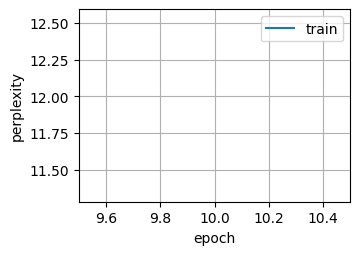

In [ ]:
num_epochs, lr = 10, 1.0
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, strategy, kerasV3=True)
